# Getting the data and FastQC

mkdir index

cp /Users/cmdb/data/rawdata/mm10_refseq-genes-chr6-50M-60M.bed /Users/cmdb/qbb2021-answers/week4

cp /Users/cmdb/data/rawdata/methylation_fastq.tar /Users/cmdb/qbb2021-answers/week4

cp /Users/cmdb/data/rawdata/chr6.fa.gz /Users/cmdb/qbb2021-answers/week4/index

tar xzf methylation_fastq.tar.gz

-Fastqc on one of the fastq files:

fastqc SRR3083926_1.chr6.fastq > fastq.out

## Bisulfite mapping with Bismark

index reference genome:

bismark_genome_preparation ~/qbb2021-answers/week4/index --parallel 7

map to genome:

bismark index -1 SRR3083929_1.chr6.fastq -2 SRR3083929_2.chr6.fastq  --B E5

bismark index -1 SRR3083926_1.chr6.fastq -2 SRR3083926_2.chr6.fastq --parallel 7 --B E4


remove duplicate reads:

deduplicate_bismark E4_pe.bam

deduplicate_bismark E5_pe.bam

extract methylation data:

bismark_methylation_extractor --bedgraph --comprehensive E4_pe.deduplicated.bam

bismark_methylation_extractor --bedgraph --comprehensive E5_pe.deduplicated.bam


sort and index reads:

samtools sort -O bam -o E4index.bam E4_pe.deduplicated.bam

samtools sort -O bam -o E5index.bam E5_pe.deduplicated.bam

samtools index E4index.bam

samtools index E5index.bam

open in IGV:

igv E4index.bam E4_pe.deduplicated.bedGraph

igv E5index.bam E5_pe.deduplicated.bedGraph.gz

pushed screenshots to GitHub of chr6:51,750,000-52,750,000

## Analysis 

Extract promoters from chr6:50,000,000-60,000,000:

awk 'BEGIN{OFS="\t"}{if ($4 == "+") print $3,$5 - 2000,$5,$13,$12,$4; else print $3,$6,$6 + 2000,$13,$12,$4;}' mm10_refseq_genes_chr6_50M_60M.bed | grep -v Rik | uniq -f 3 | sort -k2,2n > promoters.bed


map methylation signal to promoters:

bedtools map  -a promoters.bed -b E4_pe.deduplicated.bedGraph -c 4 > E4mapped.txt

bedtools map  -a promoters.bed -b E5_pe.deduplicated.bedGraph.gz -c 4 > E5mapped.txt

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
#from spicy import stats
import numpy as np

In [21]:
#make dataframe of mapped methylation scores to promoter genes
df_E4 = pd.read_csv("E4mapped.txt", sep = '\t', header = None)
df_E4.columns = ['CHR','start','end','gene','four','five','E4sum']
df_E4

,CHR,start,end,gene,four,five,E4sum
0,chr6,50108240,50110240,Mpp6,0,+,0
1,chr6,50261769,50263769,Dfna5,0,-,0
2,chr6,50382837,50384837,Osbpl3,0,-,0
3,chr6,50566474,50568474,Cycs,0,-,133.3333333
4,chr6,50570397,50572397,Mir6371,0,+,700
...,...,...,...,...,...,...,...
102,chr6,58831699,58833699,Herc3,0,+,0
103,chr6,58907126,58909126,Nap1l5,0,-,866.6666667
104,chr6,59024502,59026502,Fam13a,0,-,0
105,chr6,59206869,59208869,Tigd2,0,+,100


In [22]:
df_E5 = pd.read_csv("E5mapped.txt", sep = '\t', header = None)
df_E5.columns = ['CHR','start','end','gene','four','five','E5sum']
df_E5

,CHR,start,end,gene,four,five,E5sum
0,chr6,50108240,50110240,Mpp6,0,+,100.000000
1,chr6,50261769,50263769,Dfna5,0,-,950.000000
2,chr6,50382837,50384837,Osbpl3,0,-,1650.000000
3,chr6,50566474,50568474,Cycs,0,-,650.000000
4,chr6,50570397,50572397,Mir6371,0,+,1916.666667
...,...,...,...,...,...,...,...
102,chr6,58831699,58833699,Herc3,0,+,850.000000
103,chr6,58907126,58909126,Nap1l5,0,-,800.000000
104,chr6,59024502,59026502,Fam13a,0,-,750.000000
105,chr6,59206869,59208869,Tigd2,0,+,950.000000


In [24]:
#subset each of the data frames for gene and sum
E4genesum = df_E4.iloc[:,[3,6]]
E4genesum

,gene,E4sum
0,Mpp6,0
1,Dfna5,0
2,Osbpl3,0
3,Cycs,133.3333333
4,Mir6371,700
...,...,...
102,Herc3,0
103,Nap1l5,866.6666667
104,Fam13a,0
105,Tigd2,100


In [26]:
E5genesum = df_E5.iloc[:,[3,6]]
E5genesum

,gene,E5sum
0,Mpp6,100.000000
1,Dfna5,950.000000
2,Osbpl3,1650.000000
3,Cycs,650.000000
4,Mir6371,1916.666667
...,...,...
102,Herc3,850.000000
103,Nap1l5,800.000000
104,Fam13a,750.000000
105,Tigd2,950.000000


# 1. Make histogram of E4.0 cumulative methylation frequency

<function matplotlib.pyplot.show(close=None, block=None)>

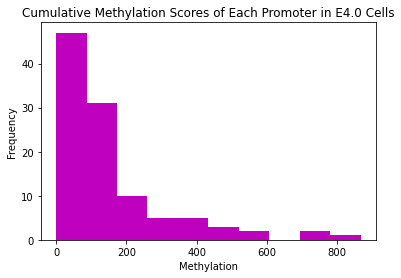

In [31]:
f = open("E4mapped.txt",'r')
m_score = []
for line in f:
    field = line.strip('\t').split()
    if field == '.':
        continue
    try:
        m_score.append(float(field[6]))
    except ValueError:
        pass
    
#plot histogram
fig, ax = plt.subplots()
ax.hist(m_score, color = 'm')
ax.set_title("Cumulative Methylation Scores of Each Promoter in E4.0 Cells")
ax.set_xlabel ("Methylation")
ax.set_ylabel ("Frequency")
plt.show

# 2. Make histogram of E5.5 cumulative methylation frequency

<function matplotlib.pyplot.show(close=None, block=None)>

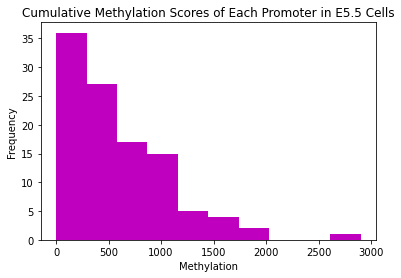

In [32]:
f = open("E5mapped.txt",'r')
m_score = []
for line in f:
    field = line.strip('\t').split()
    if field == '.':
        continue
    try:
        m_score.append(float(field[6]))
    except ValueError:
        pass
    
#plot histogram
fig, ax = plt.subplots()
ax.hist(m_score, color = 'm')
ax.set_title("Cumulative Methylation Scores of Each Promoter in E5.5 Cells")
ax.set_xlabel ("Methylation")
ax.set_ylabel ("Frequency")
plt.show

# 3. Scatterplot of E4.0 by E5.5 promoter methlylation scores. Color the hox genes a different color than the remaining genes

In [40]:
#merge sum dataframes 
df = E4genesum.merge(E5genesum, on='gene')
df

,gene,E4sum,E5sum
0,Mpp6,0,100.000000
1,Dfna5,0,950.000000
2,Osbpl3,0,1650.000000
3,Cycs,133.3333333,650.000000
4,Mir6371,700,1916.666667
...,...,...,...
102,Herc3,0,850.000000
103,Nap1l5,866.6666667,800.000000
104,Fam13a,0,750.000000
105,Tigd2,100,950.000000


In [43]:
#Get all the hox genes
E4_hox = []
E4_all = []
E5_hox = []
E5_all = []
for i, row in df.iterrows():
    if row['E4sum'] == '.' or row['E5sum']== '.':
        continue
    E4_all.append(float(row['E4sum']))
    E5_all.append(float(row["E5sum"]))
    if row['gene'].startswith('Hox'):
        E4_hox.append(float(row['E4sum']))
    if row['gene'].startswith('Hox'):
         E5_hox.append(float(row['E5sum']))
print(E4_all,E5_all)

[0.0, 0.0, 0.0, 133.3333333, 700.0, 300.0, 0.0, 100.0, 100.0, 50.0, 150.0, 100.0, 50.0, 100.0, 0.0, 100.0, 0.0, 100.0, 0.0, 450.0, 100.0, 100.0, 500.0, 200.0, 310.0, 400.0, 200.0, 0.0, 200.0, 0.0, 400.0, 400.0, 0.0, 600.0, 50.0, 66.66666667, 300.0, 550.0, 200.0, 0.0, 300.0, 500.0, 0.0, 100.0, 100.0, 50.0, 50.0, 0.0, 50.0, 116.6666667, 0.0, 200.0, 200.0, 100.0, 0.0, 100.0, 0.0, 100.0, 200.0, 700.0, 100.0, 50.0, 0.0, 300.0, 125.0, 100.0, 350.0, 0.0, 0.0, 100.0, 100.0, 350.0, 150.0, 50.0, 0.0, 0.0, 200.0, 12.5, 0.0, 50.0, 200.0, 14.28571429, 0.0, 50.0, 0.0, 100.0, 100.0, 33.33333333, 0.0, 100.0, 0.0, 233.3333333, 100.0, 100.0, 0.0, 0.0, 0.0, 100.0, 150.0, 125.0, 0.0, 0.0, 866.6666667, 0.0, 100.0, 0.0] [100.0, 950.0, 1650.0, 650.0, 1916.6666670000002, 1383.333333, 400.0, 1433.333333, 1083.333333, 0.0, 0.0, 700.0, 250.0, 2900.0, 50.0, 0.0, 0.0, 0.0, 750.0, 450.0, 283.3333333, 500.0, 183.33333330000002, 400.0, 266.6666667, 0.0, 450.0, 616.6666667000001, 0.0, 100.0, 100.0, 100.0, 200.0, 550.0

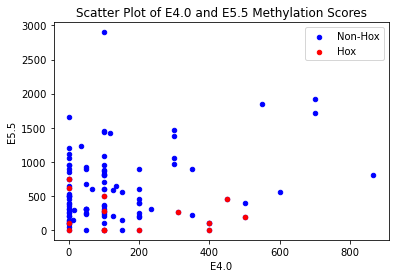

In [50]:
#plot scatter

fig, ax = plt.subplots()
ax.scatter(x = E4_all, y = E5_all, color = 'blue', s=20, label = "Non-Hox")
ax.scatter(x = E4_hox, y = E5_hox, color = 'red', s = 20, label = 'Hox')
ax.set_title("Scatter Plot of E4.0 and E5.5 Methylation Scores")
ax.set_xlabel("E4.0")
ax.set_ylabel("E5.5") 
ax.legend()
plt.show()

# 4. T-tests

In [58]:
import scipy
from scipy import stats

In [59]:
#E4
resultsE4 = scipy.stats.ttest_ind(E4_hox, E4_all)
resultsE4.pvalue

0.26919025040246874

In [60]:
#E5
resultsE5 = scipy.stats.ttest_ind(E5_hox, E5_all)
resultsE5.pvalue

0.011599661264754027